## Vision Transformer (ViT) Fine-Tuning on Modified Mini-GCD Dataset for Cloud Image Classification

### 0. Setup Environment

#### 0.1 Library Imports

In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.optim import AdamW
from transformers import ViTModel, ViTForImageClassification, ViTFeatureExtractor
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR


#### 0.2 Checking GPU availability

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

True
1
0
NVIDIA GeForce RTX 3050 Ti Laptop GPU
cuda


#### 0.3 Setting hyperparams

In [3]:
# Dataset directories
data_dirs = [ "mini-GCD-modified", "GCD-modified"] # Dataset directories
selected_data_dir = data_dirs[0] # Selected dataset directory

# Model directory and filename
model_folder = "models" # Model folder
model_filename = os.path.join(model_folder, "vit_model.pth") # Model filename

# Training hyperparameters
num_epochs = 30 # Number of epochs to train
patience = 10 # Number of epochs with no improvement before early stopping

# Results directory
scenario = "v2-all-classes" # Scenario name
results_dir = "results/vit/" + selected_data_dir + "/" + scenario + "/" # Results directory

#### 0.4 Create Directories and Utility Functions

In [4]:
# Create directories
os.makedirs(model_folder, exist_ok=True)

# Create results directory
def try_create_results_dir(results_dir):
    os.makedirs(results_dir, exist_ok=True)
    print(f"Results Directory: {results_dir}")

#### 1. Loading the Dataset

In [5]:
# Define train dataloader with online data augmentation
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Define validation and test dataloaders
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Specify the dataset directories
train_dir = os.path.join(selected_data_dir, "train")
val_dir = os.path.join(selected_data_dir, "val")
test_dir = os.path.join(selected_data_dir, "test")

# Load the datasets
train_dataset = ImageFolder(root=train_dir, transform=transform_train)
val_dataset = ImageFolder(root=val_dir, transform=transform_val)
test_dataset = ImageFolder(root=test_dir, transform=transform_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Class Names
class_names = train_dataset.classes
print(f"Classes: {class_names}")

# Show number of training samples per class
train_class_counts = {class_names[i]: 0 for i in range(len(class_names))}
for _, label in train_dataset:
    train_class_counts[class_names[label]] += 1
print("Train Class Counts:", train_class_counts)

# Display the number of training samples
print(f"Total number of training samples: {len(train_dataset)}")

Classes: ['1_cumulus', '2_altocumulus', '3_cirrus', '4_clearsky', '5_stratocumulus', '6_cumulonimbus', '7_mixed']
Train Class Counts: {'1_cumulus': 49, '2_altocumulus': 49, '3_cirrus': 49, '4_clearsky': 49, '5_stratocumulus': 49, '6_cumulonimbus': 49, '7_mixed': 49}
Total number of training samples: 343


#### 1.3. Display Sample Images

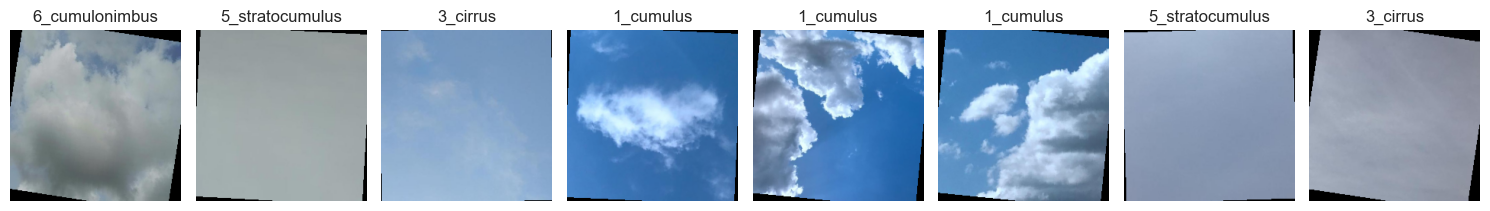

In [6]:
# Display Sample Images
def show_images(dataloader, class_names):
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for idx, ax in enumerate(axes):
        img = images[idx].permute(1, 2, 0).numpy()
        img = (img * 0.5 + 0.5)  # Unnormalize
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(class_names[labels[idx]])
    plt.tight_layout()
    plt.show()

show_images(train_loader, class_names)

### 2. Load ViT and Feature Extractor (Pre-trained)

In [7]:
# Instantiate ViT feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

C:\global_envs\pytorch_env\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


#### 2.1. Setup ViT-based Image Classifier with ViT Feature Extractor

In [8]:
# Define the ViTClassifier with ViT feature extractor
class ViTClassifier(nn.Module):
    def __init__(self, vit_model, num_classes):
        super(ViTClassifier, self).__init__()
        self.vit_model = vit_model
        self.norm = nn.LayerNorm(vit_model.config.hidden_size)  # Layer normalization
        self.dropout = nn.Dropout(0.3)  # Lower dropout rate
        self.mlp = nn.Sequential(
            nn.Linear(vit_model.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Use CLS token for feature representation
        cls_token = self.vit_model(x).last_hidden_state[:, 0, :]
        features = self.norm(cls_token)
        features = self.dropout(features)
        out = self.mlp(features)
        return out

def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Instantiate classifier
num_classes = len(class_names)
classifier = ViTClassifier(vit_model, num_classes).to(device)
print(f"Trainable Parameters: {count_trainable_params(classifier):,}")

# Define Optimizer
# optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
optimizer = AdamW(classifier.parameters(), lr=3e-5, weight_decay=0.01)

# Define Learning rate scheduler
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# Define Loss function
# criterion = nn.CrossEntropyLoss()
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

Trainable Parameters: 86,788,103


### 3. Train the model

In [9]:
# Train the model
def train_model(classifier, train_loader, val_loader, epochs=30):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    current_epochs = 0

    # Training and validation loop
    for epoch in range(epochs):
        current_epochs = epoch + 1

        classifier.train()

        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = classifier(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation loop
        classifier.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = classifier(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        # Update learning rate
        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(classifier.state_dict(), model_filename)
            saved = True
        else:
            patience_counter += 1
            saved = False
            if patience_counter >= patience:
                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} -> Early Stopping")
                break

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}" + (" [*]" if saved else ""))

    return train_losses, val_losses, current_epochs

def plot_losses(train_losses, val_losses, num_epochs=num_epochs):
    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Train the model and plot losses
train_losses, val_losses, current_epochs = train_model(classifier, train_loader, val_loader, epochs=num_epochs)
plot_losses(train_losses, val_losses, num_epochs=current_epochs)

Epoch 1/30, Train Loss: 1.7240, Val Loss: 1.7070 [*]
Epoch 2/30, Train Loss: 1.0877, Val Loss: 1.5453 [*]


KeyboardInterrupt: 

#### 3.1. (Re)load the Model

In [ ]:
# Saving is currently handled in the training loop
# torch.save(classifier.state_dict(), model_filename)

# Load the model
classifier.load_state_dict(torch.load(model_filename))

# Evaluate the model
# classifier.eval()

### 4. Evaluation

#### 4.1. Utility Functions for Evaluation

In [ ]:
# Evaluate Model
def predict_model(classifier, dataloader: DataLoader, class_names):
    """
    Utility function to predict model on a dataset
    :param classifier:
    :param dataloader:
    :param class_names:
    :return:
    """
    classifier.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = classifier(inputs)

            # Get probabilities and predictions
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

def generate_confusion_matrix(labels, preds, class_names, save_results=False):
    """
    Utility function to generate confusion matrix
    :param labels:
    :param preds:
    :param class_names:
    :return:
    """
    # Create Confusion Matrix
    cm = confusion_matrix(labels, preds, labels=range(len(class_names)))

    # Plot Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.axis("off")

    if save_results:
        try_create_results_dir(results_dir)
        plt.savefig(results_dir + "confusion_matrix.png")

    plt.show()

def generate_classification_report(labels, preds, class_names, save_results=False):
    """
    Utility function to generate classification report
    :param labels:
    :param preds:
    :param class_names:
    :return:
    """
    # Generate Classification Report
    report = classification_report(labels, preds, target_names=class_names)
    print(report)

    if save_results:
        try_create_results_dir(results_dir)
        with open(results_dir + "classification_report.txt", "w") as f:
            f.write(report)

def evaluate_model(classifier, dataloader, class_names, save_results=False):
    """
    Utility wrapper function to evaluate model on a dataset
    :param classifier:
    :param dataloader:
    :param class_names:
    :return:
    """
    preds, labels, probs = predict_model(classifier, dataloader, class_names)
    generate_confusion_matrix(labels, preds, class_names, save_results)
    generate_classification_report(labels, preds, class_names, save_results)
    return preds, labels, probs

#### 4.2. Utility Function for Plotting Random Samples

In [ ]:
# Plot Random Samples
def plot_random_samples(dataset, preds, labels, probs, class_names, num_cols=4, num_samples=5, save_results=False):
    num_samples = min(num_samples, len(dataset))

    # Randomly select indices
    random_indices = random.sample(range(len(dataset)), num_samples)

    # Calculate number of rows needed
    num_rows = (num_samples + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
    axes = axes.flatten()

    for i, idx in enumerate(random_indices):
        image, true_label = dataset[idx]
        image = (image * 0.5 + 0.5)  # Unnormalize
        image = np.clip(image, 0, 1)
        pred_label = preds[idx]
        prob = probs[idx, pred_label]  # Probability of predicted class

        axes[i].imshow(image.permute(1, 2, 0))  # Convert CHW to HWC for plotting
        axes[i].axis("off")
        axes[i].set_title(
            f"True: {class_names[true_label]}\n"
            f"Pred: {class_names[pred_label]} ({prob:.2f})"
        )

    # Hide any remaining empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()

    if save_results:
        try_create_results_dir(results_dir)
        plt.savefig(results_dir + "random_samples.png")

    plt.show()

#### 4.3. Evaluate Model on train and test datasets

In [ ]:
# Evaluate Model on train dataset
evaluate_model(classifier, train_loader, class_names)

# Evaluate Model on test dataset
preds, labels, probs = evaluate_model(classifier, test_loader, class_names, save_results=True)

# Plot random samples
plot_random_samples(test_dataset, preds, labels, probs, class_names, num_cols=4, num_samples=16, save_results=True)